# Mean profiles from CNV files

In [64]:
import unisacsi.Ocean as Oc
#import unisacsi.Meteo as Met
#from unisacsi.MET_model_download import download_MET_model_static_fields, download_MET_model_data
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import gsw
import cmocean as cmo

In [65]:
def compute_mean(CTD, variable, stationnames):
    CTD_i,Z,_,_ = Oc.CTD_to_grid(CTD, stationnames,interp_opt=0)
    df = pd.DataFrame(CTD_i[variable],index=Z
                    ,columns=stationnames
                   )
    df_mean = df.mean(axis=1)
    
    return df, df_mean

In [66]:
def plot_profiles(df, df_mean, ax):
    ax.plot(df, df.index, color='Gray', alpha=.5)
    ax.plot(df_mean, df_mean.index, lw=2)

    ax.invert_yaxis()

In [67]:
def smooth_profile(df_mean, mld, window=5):
    mixed = df_mean[:mld].mean()
    df_smooth = df_mean.rolling(window=window, center=True).mean()
    
    df_smooth[:mld] = mixed
    
    return df_smooth

In [68]:
# path to cnv-files. Should be on the format Sta0001.cnv (Sta followed by four digits)
path_data = '/home/alsjur/PhD/Kurs/AGF-811/data/CTD/PolarsysselCTD/Adventfjorden/221103/'
#path_data = '/home/alsjur/PhD/Kurs/AGF-811/data/CTD/PolarsysselCTD/Adventfjorden/221031/'

In [69]:
# Read in files
CTD = Oc.read_CTD(path_data)
advent2 = [f'A{i}' for i in range(1,16)]

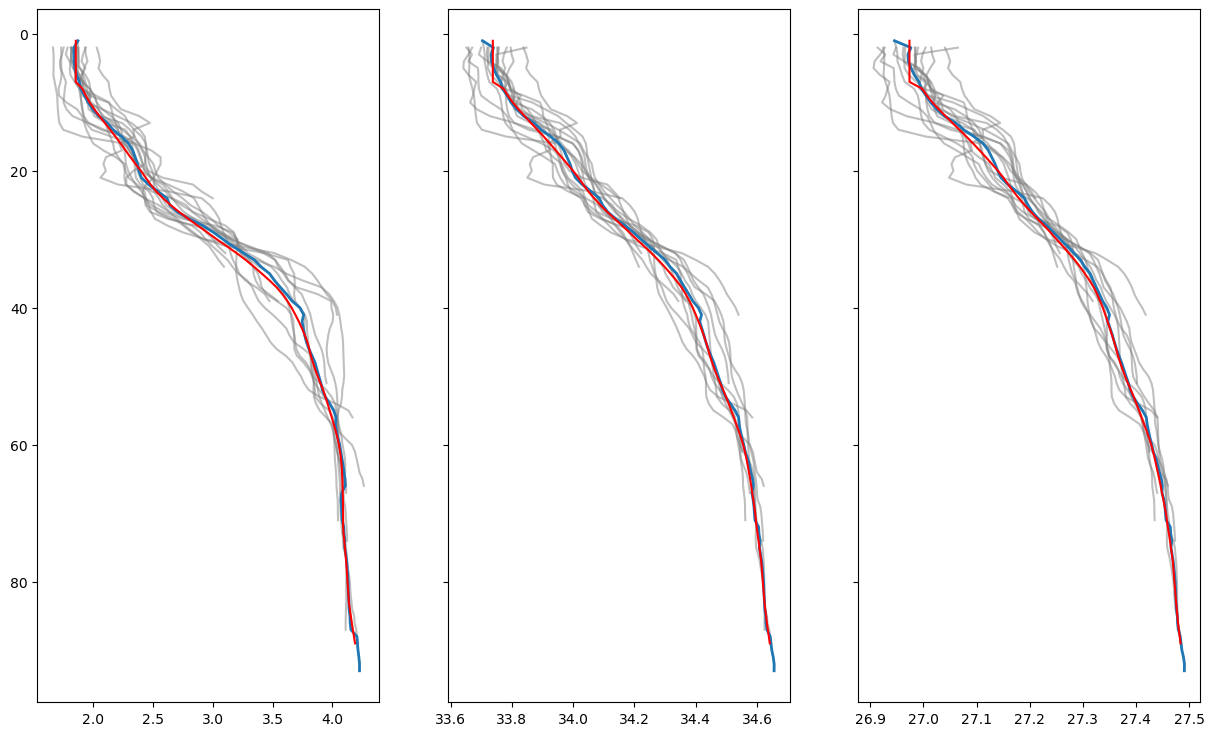

In [70]:
window = 10
mld=7

dfT, dfT_mean = compute_mean(CTD, 'T', advent2)
dfS, dfS_mean = compute_mean(CTD, 'S', advent2)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', advent2)

dfT_smooth = smooth_profile(dfT_mean, mld, window)
dfS_smooth = smooth_profile(dfS_mean, mld, window)
dfs_smooth = smooth_profile(dfs_mean, mld, window)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)

axT.plot(dfT_smooth, dfT_smooth.index, color='red')
axS.plot(dfS_smooth, dfs_smooth.index, color='red')
axs.plot(dfs_smooth, dfs_smooth.index, color='red')

In [71]:
path_data = '/home/alsjur/PhD/Kurs/AGF-811/data/CTD/PolarsysselCTD/Adventfjorden/221031/'
# Read in files
CTD = Oc.read_CTD(path_data)
advent1 = [f'{i}' for i in CTD.keys()]

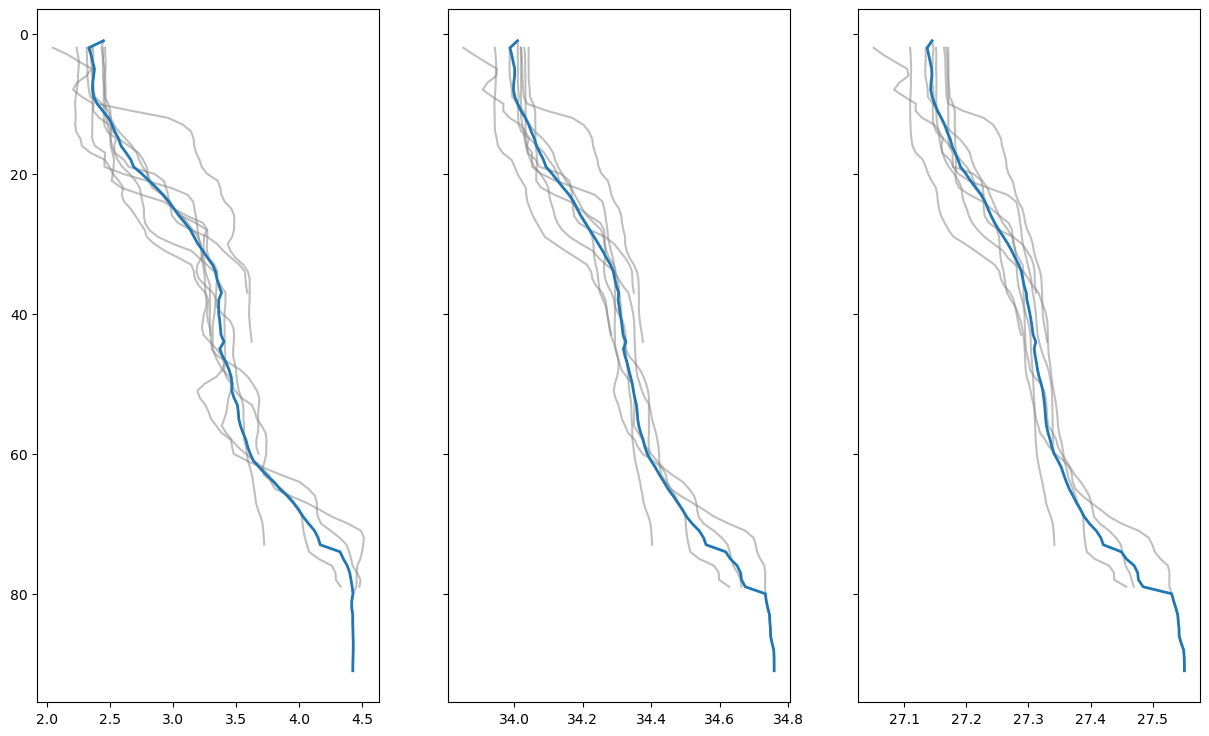

In [72]:
dfT, dfT_mean = compute_mean(CTD, 'T', advent1)
dfS, dfS_mean = compute_mean(CTD, 'S', advent1)
dfs, dfs_mean = compute_mean(CTD, 'SIGTH', advent1)

fig, [axT, axS, axs] = plt.subplots(1,3, sharey=True, figsize=(15,9))
plot_profiles(dfT, dfT_mean, axT)
plot_profiles(dfS, dfS_mean, axS)
plot_profiles(dfs, dfs_mean, axs)